In [1]:
! pip install -q kaggle
# from google.colab import files
# files.upload()
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/anime-faces

Mounted at /content/drive
 98% 434M/441M [00:30<00:00, 16.9MB/s]
100% 441M/441M [00:30<00:00, 15.2MB/s]


In [2]:
!unzip -qq anime-faces.zip

In [3]:
# !pip install -U tensorflow==2.8.0
import tensorflow as tf
print(tf.__version__)
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import cv2
from IPython import display

2.8.0


In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
BATCH_SIZE = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [6]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     directory="/kaggle/input/anime-faces/data/",
#     validation_split=0.1,
#     subset="training",
#     seed=124,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE
# )
# os.mkdir("/content/gif_stash")
list_ds = tf.data.Dataset.list_files(str('/content/data/*/*'), shuffle=True)
AUTOTUNE = tf.data.AUTOTUNE
def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    return img
    # return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
train_ds = list_ds.map(decode_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x: ((tf.cast(x, tf.float32)/127.5)-1)) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [7]:
len(train_ds)

21551

In [8]:
def perf(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
# train_ds = train_ds.map(lambda x: ((tf.cast(x, tf.float32)/255.0) - 1)) 
train_ds = perf(train_ds)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


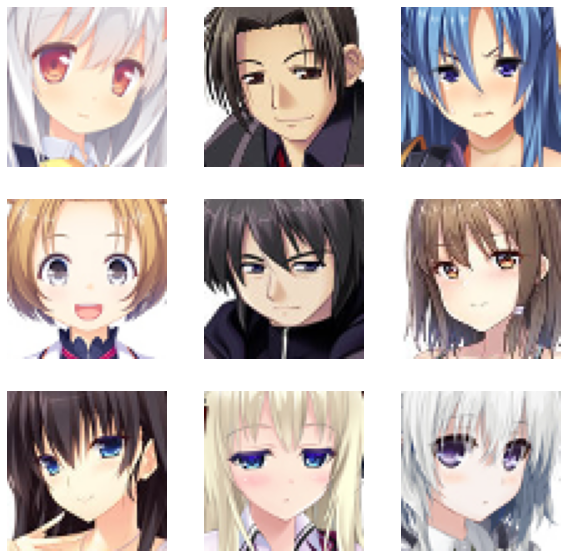

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        print(images[i].shape)
        # plt.imshow(images[i].numpy().astype("uint8"))
        plt.imshow(images[i, :, :, :]*0.5+0.5)
        plt.axis("off")

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=(128,)))
    
    model.add(layers.Dense(4*4*1024, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1,1), padding="same", use_bias=False))
    assert model.output_shape == (None, 4, 4, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding="same", use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 64, 64, 3)
    
    return model



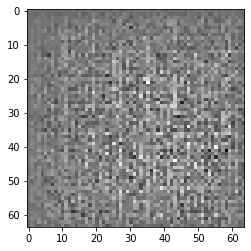

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

In [12]:
def make_disc_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding="same", input_shape=[64,64,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding="same", input_shape=[64,64,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2,2), padding="same", input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)

    model.add(layers.Conv2D(512, (5, 5), strides=(2,2), padding="same", input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    print(model.output_shape)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # negative for fake, positive for real
    print(model.output_shape)
    
    return model



In [13]:
disc = make_disc_model()
decision = disc(generated_image)
print(decision)

(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 4, 4, 512)
(None, 1)
tf.Tensor([[-0.00010186]], shape=(1, 1), dtype=float32)


In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
EPOCHS = 50
noise_dim = 128
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
generator_loss_hist, discriminator_loss_hist = [], []

In [20]:
checkpoint_dir = '/content/drive/MyDrive/anime-checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 disc=disc)


In [21]:
@tf.function
def train_step(images, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape(persistent=True) as gen_tape, tf.GradientTape(persistent=True) as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = disc(images, training=True)
        fake_output = disc(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        generator_loss_hist.append(gen_loss.numpy())
        discriminator_loss_hist.append(disc_loss.numpy())
    # print("Generator_loss: {} Discriminator loss: {}".format(gen_loss, disc_loss))

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = gen_tape.gradient(disc_loss, disc.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, disc.trainable_variables))
    
    return gen_loss, disc_loss

In [22]:
def save_loss(a, b, e, t):
  with open("logs.txt", "a+") as f:
    f.write("Epoch {}/{} Generator loss: {} Discriminator loss: {}\nTime for epoch is {} sec\n".format(e, EPOCHS, a, b, time.time()-t))
    f.close()

In [23]:
def train(dataset, epochs):
    for epoch in range(epochs):
      start = time.time()
      for image_batch in dataset:
          gen_loss, disc_loss = train_step(image_batch, epoch)

          display.clear_output(wait=True)
          generate_and_save_images(generator,
                                  epoch + 1,
                                  seed)
      save_loss(gen_loss.numpy(), disc_loss.numpy(), epoch, start)
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # predictions[i, :, :, 0] * 127.5 + 127.5
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('gif_stash/image_at_epoch_{:04d}.png'.format(epoch))
    # plt.close(fig)
    plt.show()

In [25]:
tf.train.latest_checkpoint(checkpoint_dir)

'/content/drive/MyDrive/anime-checkpoints/ckpt-23'

In [30]:
# to restore a checkpoint (assert_nontrivial_match for different root matches)
reader = tf.train.load_checkpoint(checkpoint_dir)
shape_from_key = reader.get_variable_to_shape_map()
dtype_from_key = reader.get_variable_to_dtype_map()
print(sorted(shape_from_key.keys()))
print()
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).assert_consumed()

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).assert_existing_objects_matched()


['_CHECKPOINTABLE_OBJECT_GRAPH', 'disc/layer_with_weights-0/bias/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-0/bias/.OPTIMIZER_SLOT/discriminator_optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-0/bias/.OPTIMIZER_SLOT/discriminator_optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-0/kernel/.OPTIMIZER_SLOT/discriminator_optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-0/kernel/.OPTIMIZER_SLOT/discriminator_optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-1/bias/.OPTIMIZER_SLOT/discriminator_optimizer/m/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-1/bias/.OPTIMIZER_SLOT/discriminator_optimizer/v/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-1/kernel/.ATTRIBUTES/VARIABLE_VALUE', 'disc/layer_with_weights-1/kernel/.OPTIMIZER_SLOT/discriminator_optimizer/m/.ATTRIBUTES/VARIABLE_

In [31]:
tf.train.latest_checkpoint(checkpoint_dir)

'/content/drive/MyDrive/anime-checkpoints/ckpt-23'

In [ ]:
generator.get_weights()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


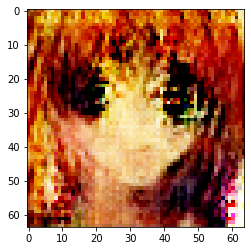

In [32]:
# Checking if weights are restored
noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

In [ ]:
tf.keras.utils.plot_model(generator, "generator.png", show_shapes=True)
tf.keras.utils.plot_model(disc, "discriminator.png", show_shapes=True)

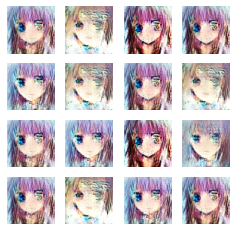

In [33]:
train(train_ds, EPOCHS)

In [34]:
!zip -r /content/gif_stash_train_3.zip /content/gif_stash

  adding: content/gif_stash/ (stored 0%)
  adding: content/gif_stash/image_at_epoch_0050.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0047.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0048.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0042.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0028.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0016.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0021.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0010.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0013.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0044.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0009.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0033.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0043.png (deflated 0%)
  adding: content/gif_stash/image_at_epoch_0039.png (deflated 0%)
  adding: content/gif_stash/image_a

In [35]:
from google.colab import files
files.download("/content/gif_stash_train_3.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

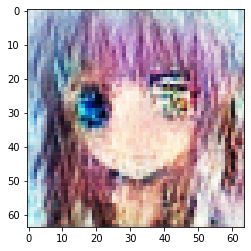

In [49]:
noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.5)

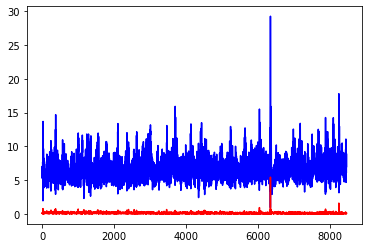

In [37]:
el = [x for x in range(1, 8450+1)]
plt.plot(el, generator_loss_hist, '-b', label='gen_loss')
plt.plot(el, discriminator_loss_hist, '-r', label='disc_loss')
plt.show()

In [38]:
anim_file = 'anime-dcgan-david-train-3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('gif_stash/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)

In [39]:
from google.colab import files
files.download("anime-dcgan-david-train-3.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>